In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pickle
from gan import * 
import torch
import matplotlib.cm as cm
from matplotlib.patches import FancyArrowPatch


In [3]:
def get_device():
    """Get the appropriate device for computation"""
    if torch.cuda.is_available():
        return torch.device('cuda:3')
    return torch.device('cpu')

device = get_device()

def get_generator(n_dim,n_channel,checkpoint_gen,task):
    device = get_device()
    with open(f'saved_model/LieGAN/{task}/args_{task}.pkl','rb') as f:
        args = pickle.load(f)

    generator = LieGenerator(n_dim,n_channel,args)
    checkpoint_gen = torch.load(checkpoint_gen, map_location=device)
    generator.load_state_dict(checkpoint_gen)
    generator = generator.to(device)

    return generator

def sampleFromLieGroup(generator, n_samples=1):
    generator = generator.to(device)
    z = generator.sample_coefficient(n_samples, device=device)
    if z.ndim == 1:
        z = z.unsqueeze(0)  # ensure shape (n_samples, c)
        
    Li = generator.getLi()  # shape (c, j, k)
    
    g = torch.matrix_exp(torch.einsum('bc,cjk->bjk', z, Li))
    g_inv = torch.matrix_exp(torch.einsum('bc,cjk->bjk', -z, Li))

    return g, g_inv

def transform(generator,x):
    z = generator.sample_coefficient(1,device) 
    gz = torch.matrix_exp(torch.einsum('bj,jkl->bkl',z,generator.getLi())) 

    x_sym = torch.einsum('bjk,btk->btj',gz,x.unsqueeze(1)).squeeze(1)


    return x_sym

In [4]:
## Spring Mass System 

# Getting the generator
n_dim = 2
n_channel = 1
generator = get_generator(n_dim,n_channel,'saved_model/LieGAN/spring_mass/spring_mass_generator_99.pt','spring_mass')

# Getting the data 
print('Loading Spring Mass dataset...') 
with open('Data/spring_mass_dataset.pkl','rb') as file:
    data_dict = pickle.load(file) 

print('Data Dictionary Keys : ',data_dict.keys())

Loading Spring Mass dataset...
Data Dictionary Keys :  dict_keys(['coords', 'test_coords', 'metadata'])


In [5]:
test_coords = data_dict['test_coords']
traj = torch.Tensor(test_coords[-1,:100,:]).to(device)

In [6]:
traj_sym = transform(generator,traj).detach()

In [7]:
traj_np = traj.cpu().detach().numpy()
traj_sym_np = traj_sym.cpu().detach().numpy()

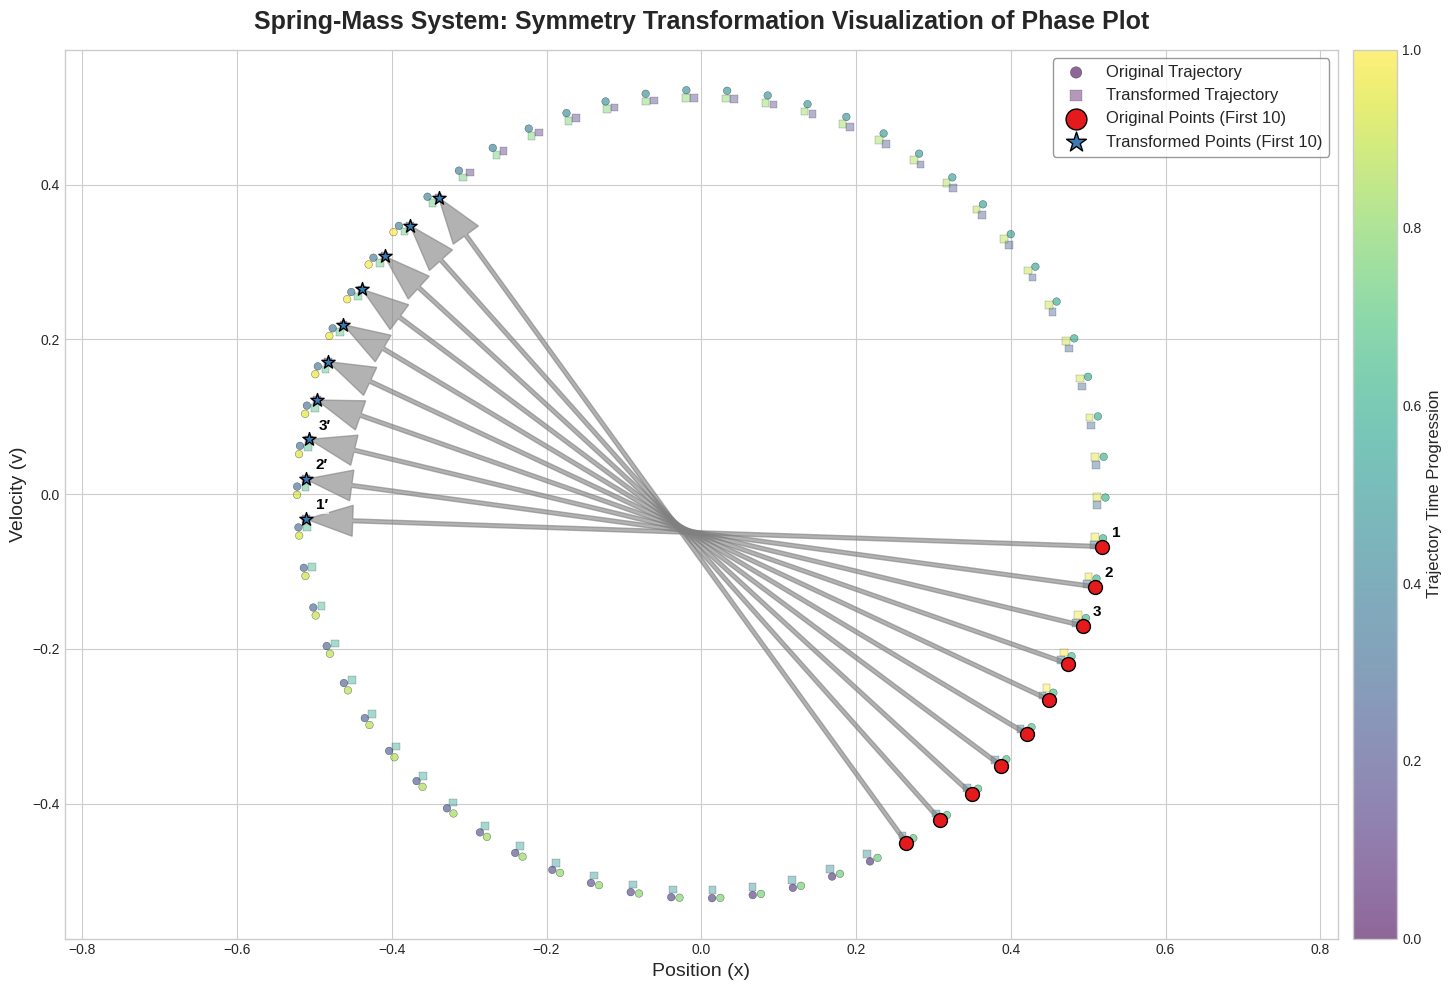

In [8]:
# --- Begin Plotting ---
plt.figure(figsize=(16, 10))
plt.style.use('seaborn-v0_8-whitegrid')

# Extract generator matrix for display
generator_matrix = generator.getLi()[0].cpu().detach().numpy()

# Create scalar values to represent time for colormap
time_values = np.linspace(0, 1, len(traj_np))

# Plot original trajectory with time-based color gradient
sc = plt.scatter(traj_np[:, 0], traj_np[:, 1], c=time_values, cmap='viridis',
                 s=30, alpha=0.6, marker='o', edgecolor='k', linewidth=0.3,
                 label='Original Trajectory')

# Plot transformed trajectory using same colormap values
plt.scatter(traj_sym_np[:, 0], traj_sym_np[:, 1], c=cm.viridis(time_values), 
            s=30, alpha=0.4, marker='s', edgecolor='k', linewidth=0.3,
            label='Transformed Trajectory')

# Highlight and connect selected points
highlight_indices = np.arange(0, min(10, len(traj_np)))
for i in highlight_indices:
    plt.arrow(traj_np[i, 0], traj_np[i, 1],
              traj_sym_np[i, 0] - traj_np[i, 0],
              traj_sym_np[i, 1] - traj_np[i, 1],
              color='gray', width=0.005, head_width=0.04, alpha=0.6,
              length_includes_head=True)

# Highlight original and transformed points
plt.scatter(traj_np[highlight_indices, 0], traj_np[highlight_indices, 1],
            s=100, color='#e41a1c', marker='o', edgecolor='k', linewidth=1.0,
            label='Original Points (First 10)')

plt.scatter(traj_sym_np[highlight_indices, 0], traj_sym_np[highlight_indices, 1],
            s=100, color='#377eb8', marker='*', edgecolor='k', linewidth=1.0,
            label='Transformed Points (First 10)')

# Annotate a few points
for i in range(min(3, len(highlight_indices))):
    plt.annotate(f'{i+1}', (traj_np[i, 0], traj_np[i, 1]),
                 xytext=(7, 7), textcoords='offset points',
                 fontsize=11, color='black', fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    plt.annotate(f'{i+1}′', (traj_sym_np[i, 0], traj_sym_np[i, 1]),
                 xytext=(7, 7), textcoords='offset points',
                 fontsize=11, color='black', fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Labels and title
plt.xlabel('Position (x)', fontsize=14)
plt.ylabel('Velocity (v)', fontsize=14)
plt.title('Spring-Mass System: Symmetry Transformation Visualization of Phase Plot',
          fontsize=18, fontweight='bold', pad=15)

# # Annotate Lie algebra generator
# generator_text = f"Lie Algebra Generator:\n${generator_matrix[0,0]:.3f} \quad {generator_matrix[0,1]:.3f}$\n${generator_matrix[1,0]:.3f} \quad {generator_matrix[1,1]:.3f}$"
# plt.annotate(generator_text, xy=(0.03, 0.97), xycoords='axes fraction',
#              bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8, edgecolor='gray'),
#              fontsize=12, ha='left', va='top')

# # Annotate phase space label
# plt.annotate("Phase Space (Position vs. Velocity)", xy=(0.5, 0.03), xycoords='axes fraction',
#              bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
#              fontsize=12, ha='center', va='bottom')

# Add legend
plt.legend(fontsize=12, frameon=True, facecolor='white', edgecolor='gray',
           loc='upper right', markerscale=1.5)

# Ensure equal axis scaling
plt.axis('equal')

# Add a valid colorbar from the scatter plot
cbar = plt.colorbar(sc, pad=0.01)
cbar.set_label('Trajectory Time Progression', fontsize=12)

# Final layout and save
plt.tight_layout()
plt.show()

In [9]:
## Simple Pendulum System 

# Getting the generator
n_dim = 2
n_channel = 1
generator = get_generator(n_dim,n_channel,'saved_model/LieGAN/pendulum/pendulum_generator_99.pt','pendulum')

# Getting the data 
print('Loading pendulum dataset...') 
with open('Data/pendulum_dataset.pkl','rb') as file:
    data_dict = pickle.load(file) 

print('Data Dictionary Keys : ',data_dict.keys())

Loading pendulum dataset...
Data Dictionary Keys :  dict_keys(['states', 'test_states', 'energies', 'test_energies', 'metadata'])


In [10]:
test_coords = data_dict['test_states']
traj = torch.Tensor(test_coords[-1,:100,:]).to(device)

In [11]:
traj_sym = transform(generator,traj).detach()

In [12]:
traj_np = traj.cpu().detach().numpy()
traj_sym_np = traj_sym.cpu().detach().numpy()

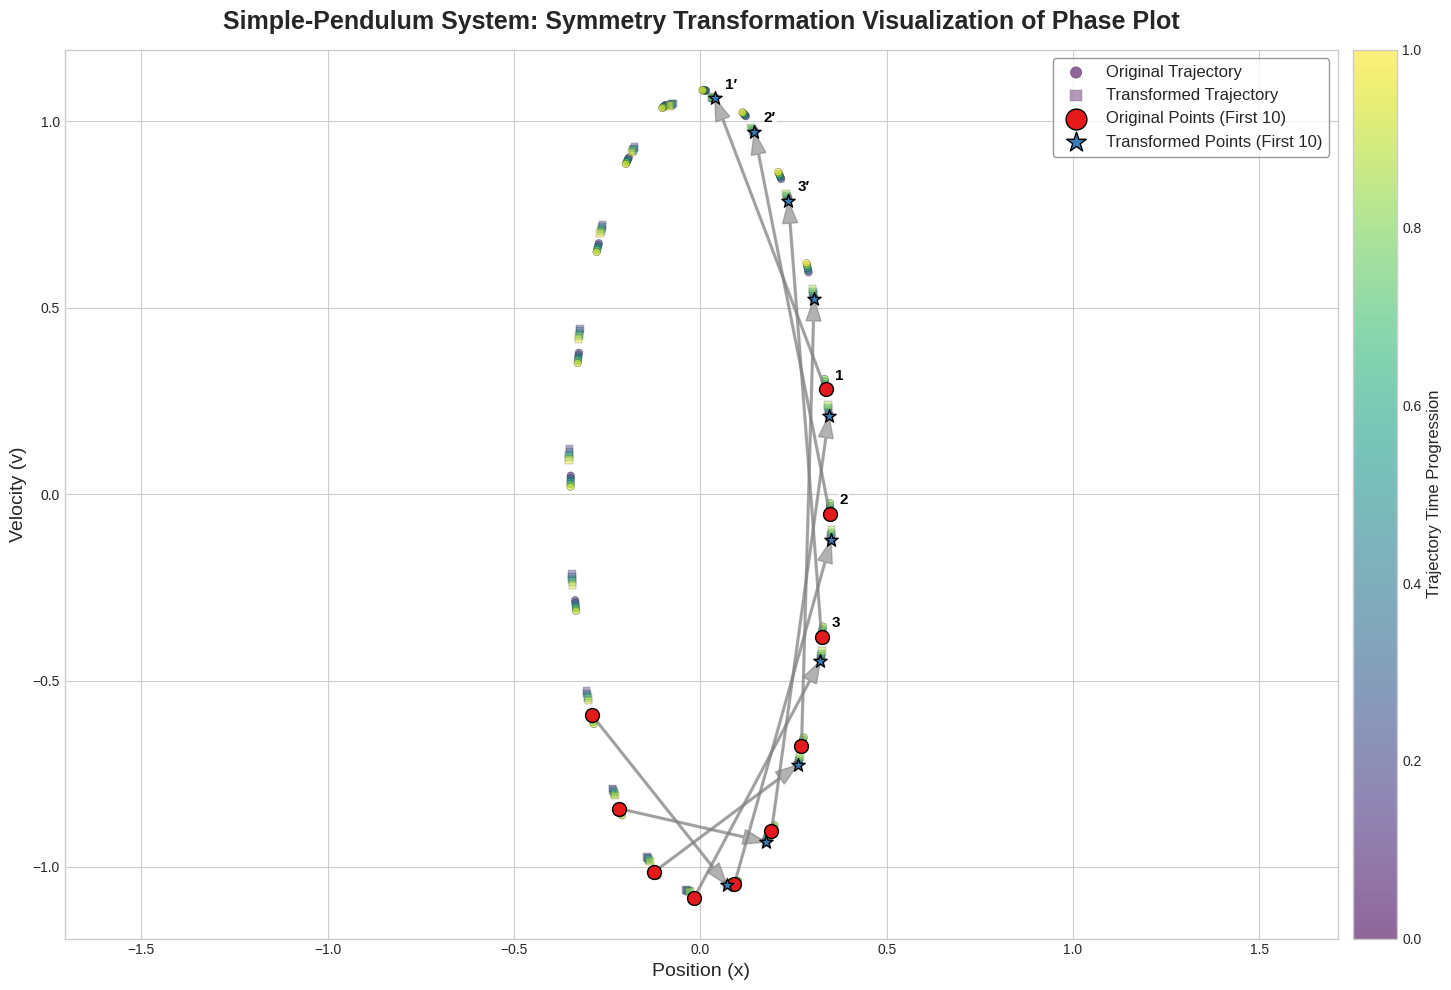

In [13]:
# --- Begin Plotting ---
plt.figure(figsize=(16, 10))
plt.style.use('seaborn-v0_8-whitegrid')

# Extract generator matrix for display
generator_matrix = generator.getLi()[0].cpu().detach().numpy()

# Create scalar values to represent time for colormap
time_values = np.linspace(0, 1, len(traj_np))

# Plot original trajectory with time-based color gradient
sc = plt.scatter(traj_np[:, 0], traj_np[:, 1], c=time_values, cmap='viridis',
                 s=30, alpha=0.6, marker='o', edgecolor='k', linewidth=0.3,
                 label='Original Trajectory')

# Plot transformed trajectory using same colormap values
plt.scatter(traj_sym_np[:, 0], traj_sym_np[:, 1], c=cm.viridis(time_values), 
            s=30, alpha=0.4, marker='s', edgecolor='k', linewidth=0.3,
            label='Transformed Trajectory')

# Highlight and connect selected points
highlight_indices = np.arange(0, min(10, len(traj_np)))
for i in highlight_indices:
    plt.arrow(traj_np[i, 0], traj_np[i, 1],
              traj_sym_np[i, 0] - traj_np[i, 0],
              traj_sym_np[i, 1] - traj_np[i, 1],
              color='gray', width=0.005, head_width=0.04, alpha=0.6,
              length_includes_head=True)

# Highlight original and transformed points
plt.scatter(traj_np[highlight_indices, 0], traj_np[highlight_indices, 1],
            s=100, color='#e41a1c', marker='o', edgecolor='k', linewidth=1.0,
            label='Original Points (First 10)')

plt.scatter(traj_sym_np[highlight_indices, 0], traj_sym_np[highlight_indices, 1],
            s=100, color='#377eb8', marker='*', edgecolor='k', linewidth=1.0,
            label='Transformed Points (First 10)')

# Annotate a few points
for i in range(min(3, len(highlight_indices))):
    plt.annotate(f'{i+1}', (traj_np[i, 0], traj_np[i, 1]),
                 xytext=(7, 7), textcoords='offset points',
                 fontsize=11, color='black', fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    plt.annotate(f'{i+1}′', (traj_sym_np[i, 0], traj_sym_np[i, 1]),
                 xytext=(7, 7), textcoords='offset points',
                 fontsize=11, color='black', fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Labels and title
plt.xlabel('Position (x)', fontsize=14)
plt.ylabel('Velocity (v)', fontsize=14)
plt.title('Simple-Pendulum System: Symmetry Transformation Visualization of Phase Plot',
          fontsize=18, fontweight='bold', pad=15)

# # Annotate Lie algebra generator
# generator_text = f"Lie Algebra Generator:\n${generator_matrix[0,0]:.3f} \quad {generator_matrix[0,1]:.3f}$\n${generator_matrix[1,0]:.3f} \quad {generator_matrix[1,1]:.3f}$"
# plt.annotate(generator_text, xy=(0.03, 0.97), xycoords='axes fraction',
#              bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8, edgecolor='gray'),
#              fontsize=12, ha='left', va='top')

# # Annotate phase space label
# plt.annotate("Phase Space (Position vs. Velocity)", xy=(0.5, 0.03), xycoords='axes fraction',
#              bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
#              fontsize=12, ha='center', va='bottom')

# Add legend
plt.legend(fontsize=12, frameon=True, facecolor='white', edgecolor='gray',
           loc='upper right', markerscale=1.5)

# Ensure equal axis scaling
plt.axis('equal')

# Add a valid colorbar from the scatter plot
cbar = plt.colorbar(sc, pad=0.01)
cbar.set_label('Trajectory Time Progression', fontsize=12)

# Final layout and save
plt.tight_layout()
plt.show()

In [20]:
## Two Body Dynamics System 

# Getting the generator
n_dim = 8
n_channel = 1
generator = get_generator(n_dim,n_channel,'saved_model/LieGAN/two_body/two_body_generator_99.pt','traj_pred')

# Getting the data 
print('Loading Two Body dataset...') 
with open('Data/two_body_dataset.pkl','rb') as file:
    data_dict = pickle.load(file) 

print('Data Dictionary Keys : ',data_dict.keys())

Loading Two Body dataset...
Data Dictionary Keys :  dict_keys(['coords', 'test_coords', 'energies', 'test_energies', 'angular_momenta', 'test_angular_momenta', 'metadata'])


In [23]:
test_coords = data_dict['test_coords']
traj = torch.Tensor(test_coords[-2,:100,:]).to(device)

traj_sym = transform(generator,traj).detach()

traj_np = traj.cpu().detach().numpy()
traj_sym_np = traj_sym.cpu().detach().numpy()

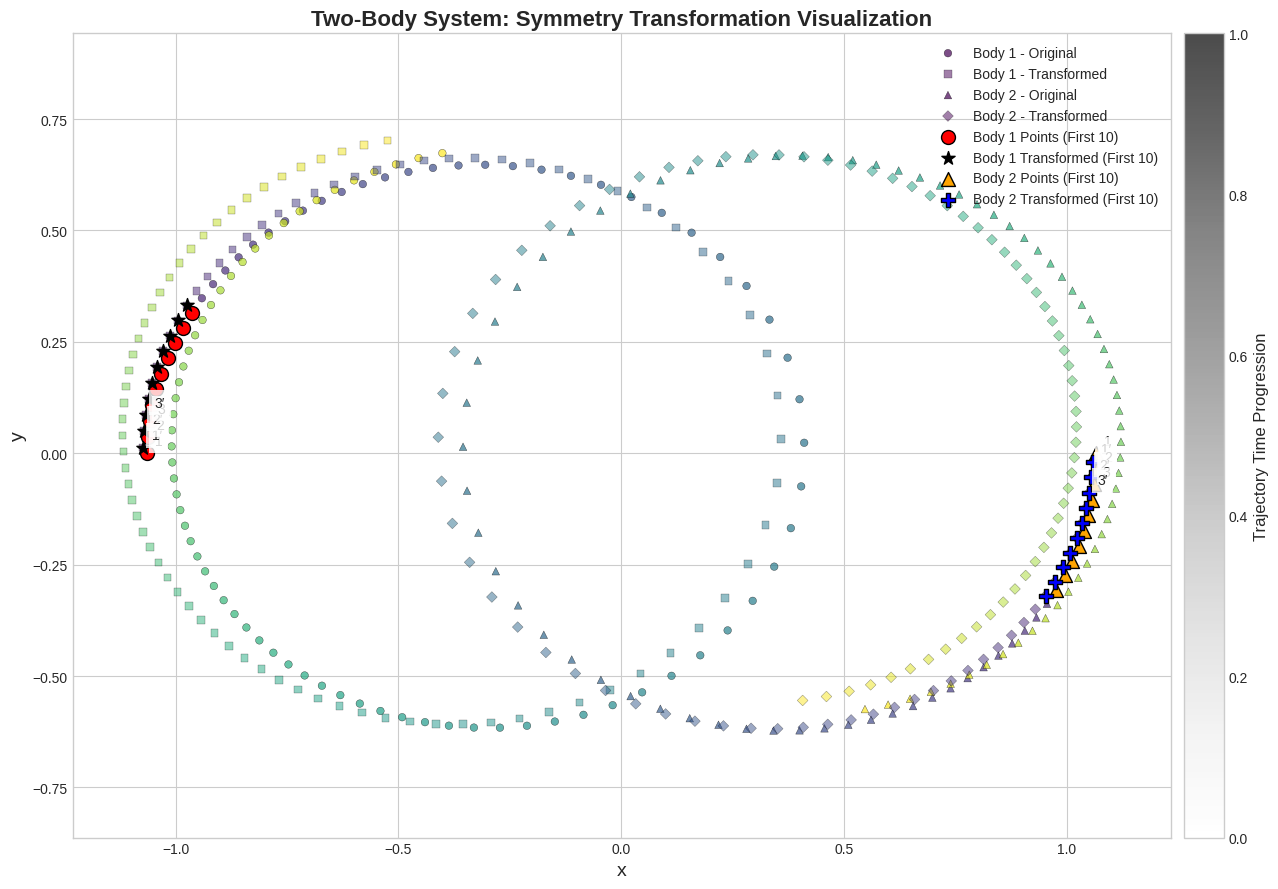

In [24]:


# Extract positions
x1, y1 = traj_np[:, 0], traj_np[:, 1]
x2, y2 = traj_np[:, 2], traj_np[:, 3]
x1_t, y1_t = traj_sym_np[:, 0], traj_sym_np[:, 1]
x2_t, y2_t = traj_sym_np[:, 2], traj_sym_np[:, 3]

# Colormap for time progression
colors = cm.viridis(np.linspace(0, 1, len(traj_np)))
highlight_indices = np.arange(0, min(10, len(traj_np)))

# Set up figure
plt.figure(figsize=(14, 9))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot original and transformed trajectories
scatter1 = plt.scatter(x1, y1, c=colors, s=30, alpha=0.7, marker='o', edgecolor='k', linewidth=0.3, label='Body 1 - Original')
plt.scatter(x1_t, y1_t, c=colors, s=30, alpha=0.5, marker='s', edgecolor='k', linewidth=0.3, label='Body 1 - Transformed')

plt.scatter(x2, y2, c=colors, s=30, alpha=0.7, marker='^', edgecolor='k', linewidth=0.3, label='Body 2 - Original')
plt.scatter(x2_t, y2_t, c=colors, s=30, alpha=0.5, marker='D', edgecolor='k', linewidth=0.3, label='Body 2 - Transformed')

# Highlight first 10 points of Body 1
plt.scatter(x1[highlight_indices], y1[highlight_indices], s=100, color='red', marker='o', edgecolor='k', linewidth=1.0, label='Body 1 Points (First 10)')
plt.scatter(x1_t[highlight_indices], y1_t[highlight_indices], s=100, color='black', marker='*', edgecolor='k', linewidth=1.0, label='Body 1 Transformed (First 10)')

# Highlight first 10 points of Body 2
plt.scatter(x2[highlight_indices], y2[highlight_indices], s=100, color='orange', marker='^', edgecolor='k', linewidth=1.0, label='Body 2 Points (First 10)')
plt.scatter(x2_t[highlight_indices], y2_t[highlight_indices], s=100, color='blue', marker='P', edgecolor='k', linewidth=1.0, label='Body 2 Transformed (First 10)')

# Annotate a few points
for i in range(min(3, len(highlight_indices))):
    plt.annotate(f'{i+1}', (x1[i], y1[i]), xytext=(6, 6), textcoords='offset points',
                 fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    plt.annotate(f'{i+1}′', (x1_t[i], y1_t[i]), xytext=(6, 6), textcoords='offset points',
                 fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    plt.annotate(f'{i+1}', (x2[i], y2[i]), xytext=(6, 6), textcoords='offset points',
                 fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    plt.annotate(f'{i+1}′', (x2_t[i], y2_t[i]), xytext=(6, 6), textcoords='offset points',
                 fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Axes and titles
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title('Two-Body System: Symmetry Transformation Visualization', fontsize=16, fontweight='bold')

# Colorbar (correctly tied to one of the scatter plots)
cbar = plt.colorbar(scatter1, pad=0.01)
cbar.set_label('Trajectory Time Progression', fontsize=12)

# Legend and layout
plt.legend(fontsize=10, loc='upper right')
plt.axis('equal')
plt.tight_layout()
plt.show()
